# QIS Cluster Analysis

### Import Libraries

In [1]:
import os
from EquityHedging.datamanager import data_manager as dm
from EquityHedging.reporting import formatter as fmt
from ClusterAnalysis.datamanager import datamanager as cdm
from EquityHedging.analytics import summary
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

from ipywidgets import interact, Dropdown

### Import Normalized Hedge Metrics

In [2]:
normalized_hm = cdm.get_normalized_hm()
# Calculate the sum of features for each strategy (row-wise sum)
normalized_hm['Total'] = normalized_hm.sum(axis=1)
normalized_hm.head(20)

,Downside Reliability,Convexity,Cost,Decay,Total
AQPEECSN index,0.558949,0.030109,0.973866,0.583562,2.146486
CMCINT index,0.682372,0.133085,0.788605,0.509589,2.113650
COSXPLNE index,0.394656,0.103044,0.884440,0.630137,2.012277
UBCIPACC index,0.491558,0.040466,0.941593,0.071233,1.544850
UBCITCCC index,0.533352,0.036417,0.933747,0.153425,1.656941
UBSIXPLN index,0.504565,0.118130,0.896486,0.421918,1.941098
XUBSCTRE index,0.381204,0.053299,0.919619,0.090411,1.444533
XUBSECTE Index,0.363424,0.058883,0.918260,0.134247,1.474814
UBCIRSER index,0.432692,0.152881,0.808532,0.386301,1.780407
UCCIRSER index,0.449872,0.127747,0.831788,0.271233,1.680640


### Import QIS Universe Returns

In [3]:
qis_uni = cdm.get_qis_uni_dict()
banks = list(qis_uni.keys())
#@interact
#def display_returns(bankret = banks):
#    return fmt.get_returns_styler(qis_uni[bankret])

### Select Number of Clusters

C:\Users\RRQ1FYQ\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.

C:\Users\RRQ1FYQ\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.



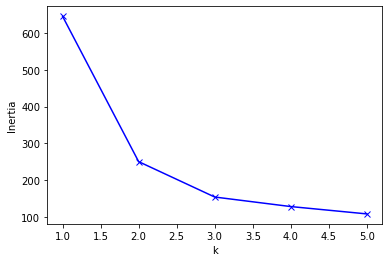

In [4]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(normalized_hm[['Downside Reliability', 'Convexity','Cost','Decay']])
X_principal = pd.DataFrame(X_principal, index = normalized_hm.index)
X_principal.columns = ['P1', 'P2']
inertia = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(normalized_hm)
    kmeanModel.fit(normalized_hm)
    inertia.append(kmeanModel.inertia_)
    
    # Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [5]:
n_cluster = 3

### Run Hierarchical Agglomerative Clustering Analysis

In [6]:
cluster_analysis = cdm.hierarchical_clustering_analysis(normalized_hm, n_cluster)
cluster_list = list(range(1,n_cluster+1))

#@interact
#def display_cluster_strats(cluster = cluster_list):
#    return list(cluster_analysis[cluster_analysis['Cluster'] == cluster].index)

### Metrics Scatter Plot

In [7]:

data= cluster_analysis.copy()

# Get the unique column names for dropdowns
feature_columns = data.columns[:-1]
data['Hover'] = list(cluster_analysis.index)

# Function to update the scatter plot
def update_plot(x_axis, y_axis):
    fig = px.scatter(
        data,
        x=x_axis,
        y=y_axis,
        color='Cluster',
        hover_data=['Hover'],
        labels={x_axis: x_axis, y_axis: y_axis},
        title='Interactive Scatter Plot with Clusters'
    )
    fig.show()

# Create interactive dropdowns
x_dropdown = Dropdown(options=feature_columns, description='X-axis:')
y_dropdown = Dropdown(options=feature_columns, description='Y-axis:')

# Create the interactive plot
interact(update_plot, x_axis=x_dropdown, y_axis=y_dropdown)



interactive(children=(Dropdown(description='X-axis:', options=('Downside Reliability', 'Convexity', 'Cost', 'D…

<function __main__.update_plot(x_axis, y_axis)>

### Find Strategies Ranked Best in Cluster

In [8]:
best_in_cluster = cdm.best_in_cluster(cluster_analysis, n_cluster)
best_in_cluster_ret = cdm.get_best_returns_data(qis_uni, best_in_cluster)
best_in_cluster

['BNPITI2U Index',
 'BNPITIU1 Index',
 'JCREOCI1 Index',
 'SGMDLVCA Index',
 'CVICCADN Index',
 'VMAF2JF4 Index']

In [9]:
def get_best_in_metric(normalized_hm_df, decay_factor = "Total"):
    best_in_metric_strats= []
   #loop through each metric and find top 2 strategies with the largest score for that metric
    for i in list(normalized_hm_df.columns.drop(["Total","Cluster"])):
        if i == "Decay":
            #gets all strategies that rank highes in decay (i.e. 1) 
            decay = normalized_hm_df[normalized_hm_df["Decay"] ==1]
            #then select top 2 strats based on total score
            top2 = decay.nlargest(2,decay_factor)
        else:
             top2 = normalized_hm_df.nlargest(2,i)
        #add strat names to list
        top2.reset_index(inplace = True)
        best_in_metric_strats = best_in_metric_strats + (top2["index"].tolist())
    
    return best_in_metric_strats

### Find Strategies Ranked Best in Metric

In [10]:
best_in_metric = get_best_in_metric(cluster_analysis, decay_factor = "Total")
best_in_metric_ret = cdm.get_best_returns_data(qis_uni, best_in_metric)
best_in_metric

['BNPIRRUS Index',
 'BNPIECUS Index',
 'BNPIESTV Index',
 'BNPIV1UE Index',
 'MQIS6RJP Index',
 'MQIS6RGB Index',
 'BNPITI2U Index',
 'BNPITIU1 Index']

In [11]:
best_in_metric2 = get_best_in_metric(cluster_analysis, decay_factor = "Convexity")
best_in_metric_ret2 = cdm.get_best_returns_data(qis_uni, best_in_metric2)
best_in_metric2

['BNPIRRUS Index',
 'BNPIECUS Index',
 'BNPIESTV Index',
 'BNPIV1UE Index',
 'MQIS6RJP Index',
 'MQIS6RGB Index',
 'CICXK5CL Index',
 'VMAC2CL2 Index']

### Find Strategies Ranked Best in Universe

In [12]:
best_in_uni =  cdm.best_in_universe(cluster_analysis)
best_in_universe_ret = cdm.get_best_returns_data(qis_uni, best_in_uni)
best_in_uni

['BNPITI2U Index',
 'BNPITIU1 Index',
 'BNPIRRUS Index',
 'BNPXTIUP Index',
 'BNPISPUS Index',
 'BNPITI2M Index',
 'BAEIPDAJ Index',
 'BAEIUPDA Index']

### Get Best In Cluster Efficient Frontier

In [13]:
best_in_cluster_ef = cdm.get_efficient_frontier(best_in_cluster_ret)

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:148: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:150: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [14]:
ef_list = ["Weights","Return Stats", "Weighted Portfolio Ret Stats","Weights for Portfolio"]
@interact
def display_returns(results = ef_list):
    return (best_in_cluster_ef[results])

interactive(children=(Dropdown(description='results', options=('Weights', 'Return Stats', 'Weighted Portfolio …

### Get Best In Metric Efficient Frontier

In [15]:
best_in_metric_ef = cdm.get_efficient_frontier(best_in_metric_ret)

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:148: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:150: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [16]:
@interact
def display_returns(results = ef_list):
    return (best_in_metric_ef[results])

interactive(children=(Dropdown(description='results', options=('Weights', 'Return Stats', 'Weighted Portfolio …

In [17]:
best_in_metric_ef2 = cdm.get_efficient_frontier(best_in_metric_ret2)

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:148: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:150: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [18]:
@interact
def display_returns(results = ef_list):
    return (best_in_metric_ef[results])

interactive(children=(Dropdown(description='results', options=('Weights', 'Return Stats', 'Weighted Portfolio …

### Get Best In Universe Efficient Frontier

In [19]:
best_in_universe_ef = cdm.get_efficient_frontier(best_in_universe_ret)


C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:148: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\RRQ1FYQ\Documents\RMP\ClusterAnalysis\datamanager\datamanager.py:150: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [20]:
@interact
def display_returns(results = ef_list):
    return (best_in_universe_ef[results])

interactive(children=(Dropdown(description='results', options=('Weights', 'Return Stats', 'Weighted Portfolio …

## Get Data

### Get Benchmark Returns

In [21]:
sptr = qis_uni['SPTR']
sptr_returns_dict= dm.get_data_dict(sptr, data_type = "Returns")

### Get UPS Weighted Hedges

In [22]:
ups_returns = pd.DataFrame(qis_uni["Weighted Hedges"])
ups_w_bmk = dm.merge_data_frames(sptr, ups_returns)
ups_notional_weights = [11,1,1,1,1,1,.25,1,1,0.4,1]
ups_returns_dict= dm.get_data_dict(ups_w_bmk, data_type = "Returns")
ups_returns_dict['Daily']

,SPTR,Down Var,Dynamic Put Spread,BNPXVT3A Index,VRR Portfolio,GW Dispersion,Correlation Hedge,Def Var,Commodity Basket,ESPRSO,EVolCon
2017-09-07,0.000050,-0.000697,-0.000194,-0.000018,0.000231,0.004681,-0.000362,0.000720,0.000719,0.000201,-0.000732
2017-09-08,-0.001446,0.001938,0.000388,0.000014,0.000422,-0.000970,-0.000093,0.000410,-0.000457,0.000402,0.000070
2017-09-11,0.010853,0.000534,-0.002760,-0.000102,-0.000758,0.000100,0.001032,-0.001367,0.001155,-0.002414,-0.000247
2017-09-12,0.003423,0.000503,-0.000704,-0.000008,-0.003151,-0.000025,-0.001012,-0.000084,0.000371,-0.000706,-0.000626
2017-09-13,0.000772,-0.002042,-0.000285,-0.000006,-0.002313,-0.001377,-0.000595,0.000358,-0.000659,0.000202,-0.000544
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,-0.007300,-0.001545,0.001141,0.000288,-0.001988,-0.000405,-0.001660,0.000432,0.000302,0.002294,0.000385
2023-05-25,0.008790,0.001074,-0.001516,-0.000420,0.002137,0.009797,0.001363,-0.000456,-0.000758,-0.001949,-0.000076
2023-05-26,0.013120,0.003091,-0.002386,-0.000466,0.001707,0.001596,-0.001314,-0.000872,0.001208,-0.001189,-0.001285
2023-05-30,0.000083,-0.001908,0.000400,-0.000081,-0.002497,0.001291,-0.002394,0.003186,0.000390,0.001105,-0.000685


### Get Best in Cluster Data Dict

In [23]:
total_notional = 8.65

In [24]:
#best in cluster notional weights from efficient frontier
best_in_cluster_notional_weights = cdm.get_notional_weights(best_in_cluster_ef["Weights for Portfolio"],total_notional, 11)

In [25]:
#best in cluster returns dict
best_in_cluster_w_bmk = dm.merge_data_frames(sptr,best_in_cluster_ret)
returns_cluster_dict = dm.get_data_dict(best_in_cluster_w_bmk, data_type = "Returns")

### Get Best in Metric Data Dict

In [26]:
#best in cluster notional weights from efficient frontier
best_in_metric_notional_weights = cdm.get_notional_weights(best_in_metric_ef["Weights for Portfolio"],total_notional, 11)
best_in_metric_notional_weights

[11,
 1.9011618653373104,
 2.017232947828801,
 0.02919483368036275,
 1.301139627998428,
 0.6119310776557826,
 2.4545095067745795,
 0.007881636960695996,
 0.3269485037640388]

In [27]:

#best in cluster returns dict
best_in_metric_w_bmk = dm.merge_data_frames(sptr,best_in_metric_ret)
returns_metric_dict = dm.get_data_dict(best_in_metric_w_bmk, data_type = "Returns")
returns_metric_dict['Daily']

,SPTR,BNPIRRUS Index,BNPIECUS Index,BNPIESTV Index,BNPIV1UE Index,MQIS6RJP Index,MQIS6RGB Index,BNPITI2U Index,BNPITIU1 Index
2017-09-07,0.000050,-0.000015,0.000235,-0.001943,-0.001280,0.00000,0.000000,0.000161,0.000100
2017-09-08,-0.001446,-0.000820,-0.001588,0.020912,0.015128,0.00000,0.000000,-0.000310,-0.000148
2017-09-11,0.010853,0.006331,0.010390,-0.049012,-0.018286,0.00000,0.000000,0.001398,0.000782
2017-09-12,0.003423,0.002563,0.003354,-0.019402,-0.009256,0.00000,0.000000,0.000081,0.000058
2017-09-13,0.000772,0.000262,0.000505,-0.036414,-0.009241,0.00000,0.000000,0.000104,0.000070
...,...,...,...,...,...,...,...,...,...
2023-05-24,-0.007300,-0.004257,-0.006828,0.001289,0.008713,0.00000,0.000000,-0.001716,-0.000837
2023-05-25,0.008790,0.004680,0.007998,-0.013998,-0.016837,0.00000,0.000000,0.002499,0.001382
2023-05-26,0.013120,0.007776,0.011401,-0.033371,-0.013825,0.00000,0.000000,0.002362,0.001310
2023-05-30,0.000083,0.000079,0.001617,-0.011058,-0.007116,0.00000,0.000000,0.002025,0.001335


In [28]:
#best in cluster notional weights from efficient frontier
best_in_metric_notional_weights2 = cdm.get_notional_weights(best_in_metric_ef2["Weights for Portfolio"],total_notional, 11)

In [29]:

#best in cluster returns dict
best_in_metric_w_bmk2 = dm.merge_data_frames(sptr,best_in_metric_ret2)
#get weighted hedges and strats
returns_metric2_dict = dm.get_data_dict(best_in_metric_w_bmk2, data_type = "Returns")

### Get Best in Universe Data Dict

In [30]:
#best in cluster notional weights from efficient frontier
best_in_universe_notional_weights = cdm.get_notional_weights(best_in_universe_ef["Weights for Portfolio"],total_notional, 11)
best_in_universe_notional_weights

[11,
 0.07139047286487865,
 1.5513351405683768,
 2.532219405765162,
 2.401493391382661,
 1.2626616804098634,
 0.6435644401147659,
 0.04966043562916571,
 0.13767503326512737]

In [31]:

#best in cluster returns dict
best_in_universe_w_bmk = dm.merge_data_frames(sptr,best_in_universe_ret)
#get weighted hedges and strats
returns_universe_dict = dm.get_data_dict(best_in_universe_w_bmk, data_type = "Returns")

### Get Equity Hedging Reports

In [ ]:
from EquityHedging.reporting.excel import reports as rp

In [ ]:
include_fi = False
strat_drop_list = []
weighted = [True, False]
new_strat = False

In [ ]:
equity_hedge_report = 'equity_hedge_analysis_best_in_cluster'
selloffs = True
grouped = True
rp.get_equity_hedge_report(equity_hedge_report, returns_cluster_dict, best_in_cluster_notional_weights, include_fi , new_strat, weighted[0], selloffs, grouped)

In [ ]:
equity_hedge_report = 'equity_hedge_analysis_best_in_metric_total'
selloffs = True
grouped = True
rp.get_equity_hedge_report(equity_hedge_report, returns_metric_dict, best_in_metric_notional_weights, include_fi , new_strat, weighted[0], selloffs, grouped)

In [ ]:
equity_hedge_report = 'equity_hedge_analysis_best_in_metric_convexity'
selloffs = True
grouped = True
rp.get_equity_hedge_report(equity_hedge_report, returns_metric2_dict, best_in_metric_notional_weights2, include_fi , new_strat, weighted[0], selloffs, grouped)

In [ ]:
equity_hedge_report = 'equity_hedge_analysis_best_in_universe'
selloffs = True
grouped = True
rp.get_equity_hedge_report(equity_hedge_report, returns_universe_dict, best_in_universe_notional_weights, include_fi , new_strat, weighted[0], selloffs, grouped)

In [ ]:
equity_hedge_report = 'equity_hedge_analysis_UPS'
selloffs = True
grouped = True
rp.get_equity_hedge_report(equity_hedge_report, ups_returns_dict, ups_notional_weights, include_fi , new_strat, weighted[0], selloffs, grouped)

### Get strat report

In [ ]:
returns_cluster = summary.get_weighted_data(best_in_cluster_w_bmk, best_in_cluster_notional_weights)
returns_cluster.rename(columns = {'Weighted Hedges':'Weighted Hedges Cluster'}, inplace = True)
wh_cluster_dict = dm.get_data_dict(pd.DataFrame(returns_cluster['Weighted Hedges Cluster']), data_type = "Returns")
wh_cluster_dict['Daily']

In [ ]:
returns_cluster = summary.get_weighted_data(best_in_cluster_w_bmk, best_in_cluster_notional_weights)
returns_cluster

In [ ]:

returns_metric = summary.get_weighted_data(best_in_metric_w_bmk, best_in_metric_notional_weights)
returns_metric.rename(columns = {'Weighted Hedges':'Weighted Hedges Metric (Total)'}, inplace = True)
wh_metric_dict = dm.get_data_dict(pd.DataFrame(returns_metric['Weighted Hedges Metric (Total)']), data_type = "Returns")

returns_metric2 = summary.get_weighted_data(best_in_metric_w_bmk2, best_in_metric_notional_weights2)
returns_metric2.rename(columns = {'Weighted Hedges':'Weighted Hedges Metric (Convexity)'}, inplace = True)
wh_metric_dict2 = dm.get_data_dict(pd.DataFrame(returns_metric2['Weighted Hedges Metric (Convexity)']), data_type = "Returns")



returns_universe = summary.get_weighted_data(best_in_universe_w_bmk, best_in_universe_notional_weights)
returns_universe.rename(columns = {'Weighted Hedges':'Weighted Hedges Universe'}, inplace = True)
wh_universe_dict = dm.get_data_dict(pd.DataFrame(returns_universe['Weighted Hedges Universe']), data_type = "Returns")

ups_weighted_hedges = summary.get_weighted_data(ups_w_bmk, ups_notional_weights)
ups_weighted_hedges.rename(columns = {'Weighted Hedges':'Weighted Hedges UPS'}, inplace = True)
wh_ups_dict = dm.get_data_dict(pd.DataFrame(ups_weighted_hedges['Weighted Hedges UPS']), data_type = "Returns")


In [ ]:
weighted_hedges_dict = dm.merge_dicts_list([sptr_returns_dict,wh_cluster_dict,wh_metric_dict,wh_metric_dict2,wh_universe_dict,wh_ups_dict])
weighted_hedges_dict['Daily']

In [ ]:
strat_report = 'Cluster Analysis Weighted Hedges'
selloffs = True
rp.generate_strat_report(strat_report, weighted_hedges_dict, selloffs = True)
